# Diagnosing diabetes with KNN

In this small notebook we use data about diabetes in female Pima Indians to see how well we can predict diabetes given variables like age, glucose level, blood pressure, and skin thickness.

We focus on two things: 
- data exploration and cleaning
- using hyperparameter tuning to find the best hyperparameter values for KNN classification

The dataset was downloaded from Kaggle on October 21, 2021.

https://www.kaggle.com/uciml/pima-indians-diabetes-database

Information about the data set can be found on the Kaggle page.

### Instructions

- Please read the entire notebook carefully!
- Note that plots are preceded by a question and followed by interpretation of the plot.
- Each problem cell begins with #@.
- Do not make changes outside the problem cells.
- Be sure to include plot titles, labels, etc. as shown in model output.
- Run your code from top to bottom before submitting.
- Do not modify the file name.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

In [2]:
# code in this cell from: 
# https://stackoverflow.com/questions/27934885/how-to-hide-code-from-cells-in-ipython-notebook-visualized-with-nbviewer
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to display/hide the code."></form>''')

### Set the random seed for repeatability

In [3]:
np.random.seed(0)

### Read the data

In [4]:
df = pd.read_csv("https://raw.githubusercontent.com/grbruns/cst383/master/diabetes.csv")

It is useful to identify the predictor and target variables right away.

In [5]:
target = 'Outcome'
predictors = list(df.columns)
predictors.remove(target)

### Data exploration

Looking at an overview of the data, we see no NA values.  All variables are numeric.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


It is helpful to look at a little of the raw data.

In [7]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


'Outcome' is the target value.  A value of 1 indicates the presence of diabetes.  

How many people represented in the data have diabetes?

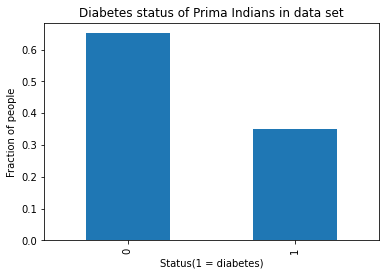

In [8]:
#@ 1  Create a bar plot that shows the fraction of patients with diabetes, and without diabetes.

# YOUR CODE HERE
size = df['Outcome'].value_counts().sum()
newDf = df['Outcome'].value_counts()

def temp(x):
  return x/size

newDf = newDf.apply(temp)
newDf.plot(kind = 'bar')
plt.title('Diabetes status of Prima Indians in data set')
plt.xlabel('Status(1 = diabetes)')
plt.ylabel('Fraction of people');

About 1/3 of the patients have diabetes, according to the data.

What are the basic statistics of the numeric variables?

In [9]:
df.describe().round(2)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.00,768.00,768.00,768.00,768.00,768.00,768.00,768.00,768.00
mean,3.85,120.89,69.11,20.54,79.80,31.99,0.47,33.24,0.35
std,3.37,31.97,19.36,15.95,115.24,7.88,0.33,11.76,0.48
min,0.00,0.00,0.00,0.00,0.00,0.00,0.08,21.00,0.00
25%,1.00,99.00,62.00,0.00,0.00,27.30,0.24,24.00,0.00
50%,3.00,117.00,72.00,23.00,30.50,32.00,0.37,29.00,0.00
75%,6.00,140.25,80.00,32.00,127.25,36.60,0.63,41.00,1.00
max,17.00,199.00,122.00,99.00,846.00,67.10,2.42,81.00,1.00


We see that there are no negative values in the dataset.  

Something that looks odd is that many variables have zero as their minimum value.  Can blood pressure really be zero?  What about skin thickness, and body mass index?  Perhaps some of the zeroes indicate bad data.

Does the data contain outliers?  This will be easier to see if the data is scaled.

In [10]:
#@ 2 Produce describe() output after using zscore normalization on each column.
# Hint: use apply() on the dataframe with SciPy function zscore.

# YOUR CODE HERE
df.apply(zscore).describe().round(2)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.00,768.00,768.00,768.00,768.00,768.00,768.00,768.00,768.00
mean,0.00,0.00,-0.00,0.00,-0.00,0.00,0.00,0.00,0.00
std,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
min,-1.14,-3.78,-3.57,-1.29,-0.69,-4.06,-1.19,-1.04,-0.73
25%,-0.84,-0.69,-0.37,-1.29,-0.69,-0.60,-0.69,-0.79,-0.73
50%,-0.25,-0.12,0.15,0.15,-0.43,0.00,-0.30,-0.36,-0.73
75%,0.64,0.61,0.56,0.72,0.41,0.58,0.47,0.66,1.37
max,3.91,2.44,2.73,4.92,6.65,4.46,5.88,4.06,1.37


We see that the maximum insulin value is more than 6 standard deviations above the mean, and the max skin thickness and diabetes pedigree function values are also large.

Box plots can help identify outliers.  When showing multiple boxplots at once, scaling is useful.

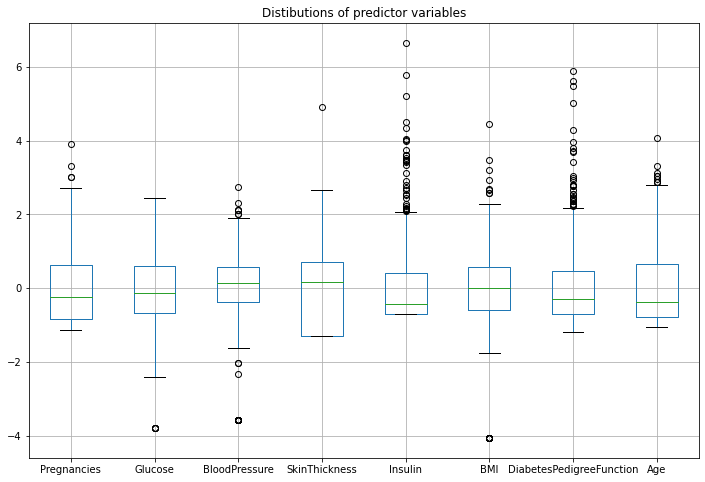

In [11]:
#@ 3 Produce box plots for all predictor values.  Scale each predictor using Z-score normalization.
# Hint: with pandas, boxplot() can be applied directly to a data frame.
# Hint: use SciPy's zscore function for normalization.

# YOUR CODE HERE
df[predictors].apply(zscore).boxplot(figsize=(12,8))
plt.title("Distibutions of predictor variables");


There seem to be many outliers in the Insulin and DiabetesPedegreeFunction variables.  

We can get a deeper feeling for zero values and outliers by plotting the data.

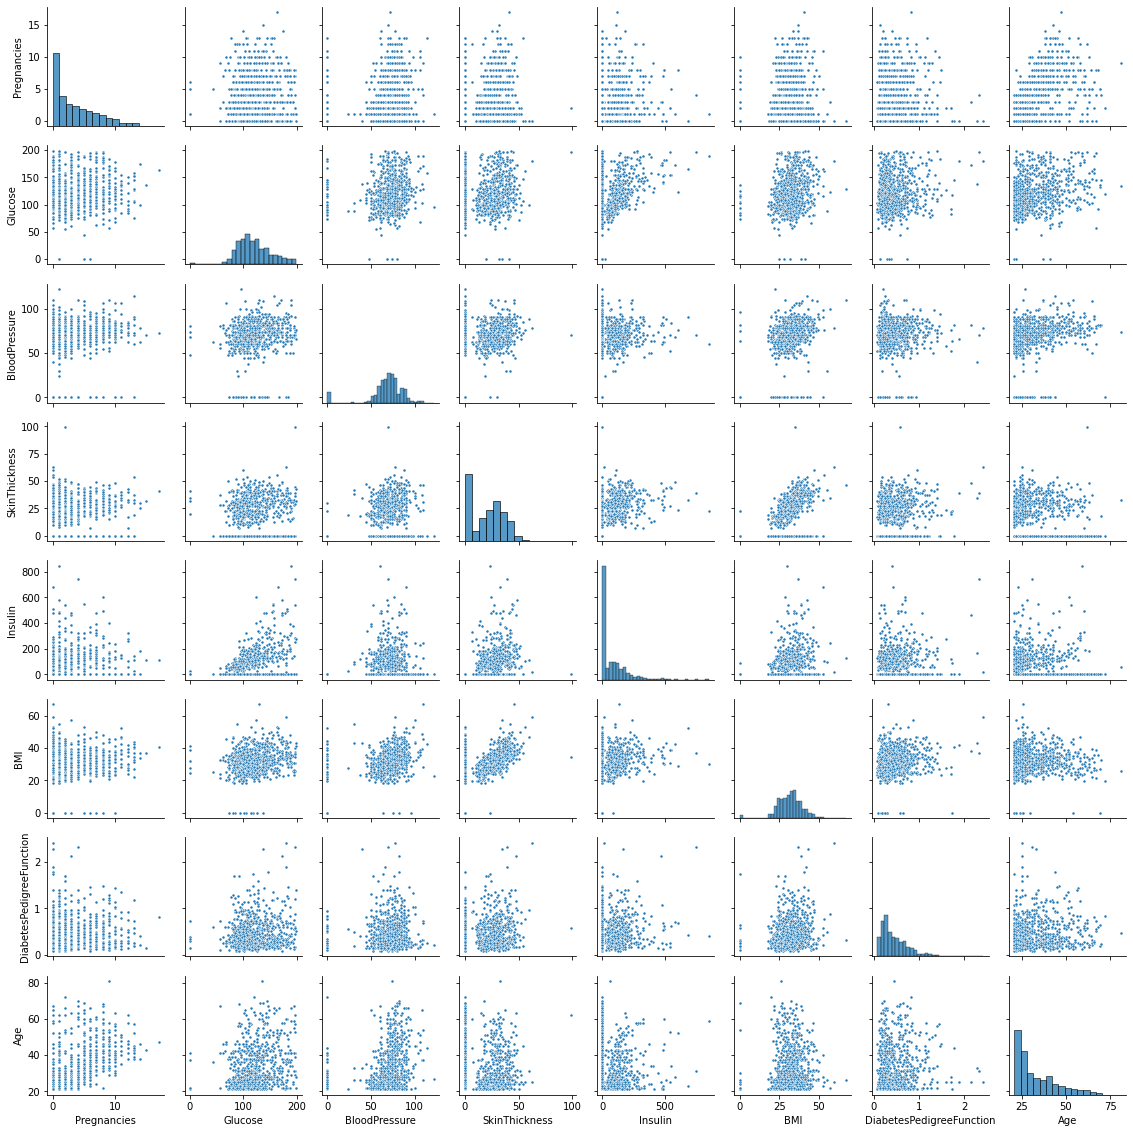

In [12]:
#@ 4 Produce a pairplot for all the predictor variables.
# Hint: use an Seaborn function that was shown in lecture.
# Hint: don't forget the predictors variable defined above.
# Hint: it takes a while for the output to be produced, so don't worry about that.

# YOUR CODE HERE
sns.pairplot(df,
vars=['Pregnancies',
'Glucose',
'BloodPressure',
'SkinThickness',
'Insulin',
'BMI',
'DiabetesPedigreeFunction',
'Age'],
markers='.',
height=2);

We find that some of the 0 values do indeed look strange.  For example, the zero BMI values look strange.  Also, some of the max values look like outliers.  For example, the largest skin thickness value.

### Investigating zero values

A concern is that zero values might represent missing data.

Let's focus first on insulin.  What is the distribution of insulin values?

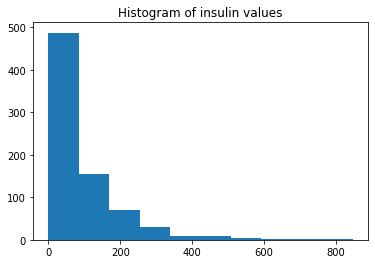

In [13]:
plt.hist(df['Insulin']);
plt.title("Histogram of insulin values");

The distribution is highly skewed.  Plotting the log may make the distribution clearer.

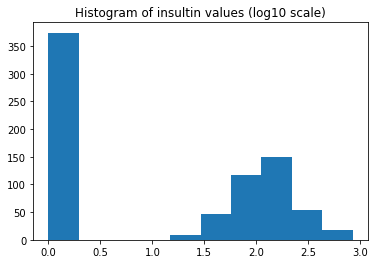

In [14]:
plt.hist(np.log10(df['Insulin']+1));
plt.title("Histogram of insultin values (log10 scale)");

This picture makes the zero insulin values look very suspicious.

What about the other predictors?  For each predictor, what fraction of the values are 0?

In [15]:
#@ 5  Show the fraction of values of each predictor that are zero.  
# Show output in decreasing order of 0 fraction.
# Hint: use the 'predictors' variable defined above. 
# Hint: use round(3)

# YOUR CODE HERE
((df[predictors] == 0).mean().round(3)).sort_values(ascending = False)

Insulin                     0.487
SkinThickness               0.296
Pregnancies                 0.145
BloodPressure               0.046
BMI                         0.014
Glucose                     0.007
DiabetesPedigreeFunction    0.000
Age                         0.000
dtype: float64

About 46% of the insulin values are zero.  This could suggest they are valid.  Also, a little background research suggests zero insulin values are possible.

Another way to understand zero values is to see how far they are away from the mean value.

In [16]:
df[predictors].apply(lambda x: x.mean()/x.std()).sort_values(ascending=False).round(3)

BMI                         4.058
Glucose                     3.781
BloodPressure               3.570
Age                         2.827
DiabetesPedigreeFunction    1.424
SkinThickness               1.287
Pregnancies                 1.141
Insulin                     0.692
dtype: float64

This backs up the idea that blood pressure values of 0 represent missing data.  

Are the 0 values in the data set clustered in some rows?
In other words, are the 0's spread evenly across people, or clustered in some people?  To look into this, we can count the number of rows with no zero values, with 1 zero value, etc.

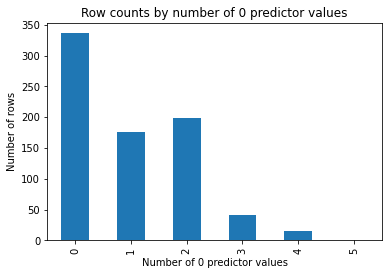

In [17]:
#@ 6  Compute the number of rows that contain no predictor values of 0,
# the number of rows that contain one predictor value of 0, etc.
# Hint: use sum() and value_counts().  Remember the 'axis' parameter of sum().
nDf = (df[predictors] == 0).sum(axis = 1).value_counts().sort_index()
nDf.plot(kind = 'bar')
plt.title("Row counts by number of 0 predictor values")
plt.xlabel("Number of 0 predictor values")
plt.ylabel("Number of rows");

We see that about 170 rows contain two zero values, but very few rows contain more than two zero values.

In the rows with more than one zero value, which predictors are 0?

In [18]:
df[(df[predictors] == 0).sum(axis=1) > 1].head(10)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
2,8,183,64,0,0,23.3,0.672,32,1
5,5,116,74,0,0,25.6,0.201,30,0
7,10,115,0,0,0,35.3,0.134,29,0
9,8,125,96,0,0,0.0,0.232,54,1
10,4,110,92,0,0,37.6,0.191,30,0
11,10,168,74,0,0,38.0,0.537,34,1
12,10,139,80,0,0,27.1,1.441,57,0
15,7,100,0,0,0,30.0,0.484,32,1
17,7,107,74,0,0,29.6,0.254,31,1
21,8,99,84,0,0,35.4,0.388,50,0


Zero values for skin thickness and insulin seem to go together.  Does a scatter plot confirm this idea?

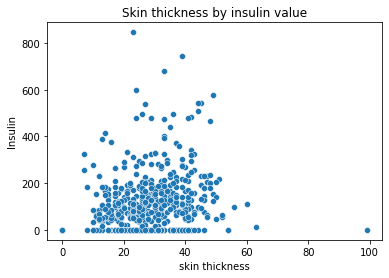

In [19]:
sns.scatterplot(data=df, x='SkinThickness', y='Insulin')
plt.xlabel('skin thickness')
plt.title('Skin thickness by insulin value');

It seems that if skin thickness is 0, then insulin is 0, because there are no skin thickness values of 0 except where insulin is 0.

Perhaps if a person's skin is very thin, it is hard to test for insulin.  Talking to a diabetes specialist would help in understanding this.

### Data preprocessing

Our strategy on zero values will be to remove rows in which BMI, Glucose, BloodPressure, or SkinThickness are 0.  An alternative approach would be to impute values for these zero values.

In [20]:
#@ 7 Modify df to to remove the rows in which BMI, Glucose, BloodPressure, or SkinThickness have value 0.
# Hint: use a boolean mask that involves those three variables.
# Hint: write an assignment statement

# YOUR CODE HERE
df = df.loc[(df[['BMI', 'Glucose', 'BloodPressure', 'SkinThickness']] != 0).all(axis=1)]

Use describe again to see the result of removing these rows.

In [21]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,532.000000,532.000000,532.000000,532.000000,532.000000,532.000000,532.000000,532.000000,532.000000
mean,3.516917,121.030075,71.505639,29.182331,114.988722,32.890226,0.502966,31.614662,0.332707
std,3.312036,30.999226,12.310253,10.523878,123.007555,6.881109,0.344546,10.761584,0.471626
min,0.000000,56.000000,24.000000,7.000000,0.000000,18.200000,0.085000,21.000000,0.000000
25%,1.000000,98.750000,64.000000,22.000000,0.000000,27.875000,0.258750,23.000000,0.000000
50%,2.000000,115.000000,72.000000,29.000000,91.500000,32.800000,0.416000,28.000000,0.000000
75%,5.000000,141.250000,80.000000,36.000000,165.250000,36.900000,0.658500,38.000000,1.000000
max,17.000000,199.000000,110.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


Put the predictor and target values into NumPy arrays.

In [22]:
X = df[predictors].values
y = df[target].values

In [23]:
print('X shape: {}'.format(X.shape))
print('y shape: {}'.format(y.shape))

X shape: (532, 8)
y shape: (532,)


Perform an 75/25 test/train split.

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

Scale the data using z-score normalization.  Note that the scaler is trained on the training data, and the trained scaler is used on both the training and test data.  The target values are not scaled.

In [25]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Basic KNN classification

In [26]:
#@ 8  Train a KNN classifier on the training data.
# Create a KNeighborsClassifier object and store it as variable 'knn'.
# Use the default values.
# Then train the classifier on the training data

# YOUR CODE HERE
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

KNeighborsClassifier()

Three important hyperparameters of a KNN classifier:
- the number of nearest neighbors ('n_neighbors' in KNeighborsClassifier())
- the distance metric  ('metric' and 'p')
- whether closer neighbors should be more important when making predictions ('weights')

If 'metric' is 'minkowski', then p = 1 means manhattan distance, and p = 2 means Euclidian distance.

Let's look at the default hyperparameters for the KNN classifier.

In [27]:
# examing default parameters
knn.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

What test accuracy is achieved with the default KNN classifier?

In [28]:
#@ 9  Compute the cross-validation accuracy of the classifier.
# Hint: use cross_val_score().
# Store your result as variable 'cv_accuracy'.

# YOUR CODE HERE
cv_accuracy = (cross_val_score(knn, X_train, y_train, scoring = "accuracy", cv = 10)).mean()

In [29]:
print('CV accuracy using default hyperparameters: {:.3f}'.format(cv_accuracy))

CV accuracy using default hyperparameters: 0.754


### Compute the accuracy we'd get by always predicting that "no diabetes".

When we compute the accuracy of a classifier, we want a baseline for comparison.  The usual baseline is the accuracy that you would get if you always predicted the most common value of the predictor variable.  In this case, the most common value of y_test is 0.

In [30]:
#@ 10  Compute the baseline accuracy by computing the fraction of the y_test values that are 0.
# Store the result as variable 'baseline_accuracy'.

# YOUR CODE HERE
baseline_accuracy = (y_test == 0).mean()

In [31]:
print('Baseline accuracy: {:.3f}'.format(baseline_accuracy))

Baseline accuracy: 0.684


So the test accuracy is significantly better than the baseline.

### Determine best k by using 10-fold cross validation

The default value of k is 5 with KNeighborsClassifier.  Is this a good value for k?

In [32]:
#@ 11  Compute 10-fold cross-validation accuracy for k=1, 3, 5, ..., 23.
# Store the accuracy values in list cv_accuracy.
# Store the k values in list ks.
# Hint: we covered this in class.  The cv-accuracy value should be the mean
# of the accuracy values for the 10 folds.
cv_accuracy = []
ks = np.arange(1,24,2)
for k in ks:
  clf = KNeighborsClassifier(n_neighbors = k)
  clf.fit(X_train, y_train)
  temp = (cross_val_score(clf, X_train, y_train, scoring = "accuracy", cv = 10)).mean()
  cv_accuracy.append(temp)


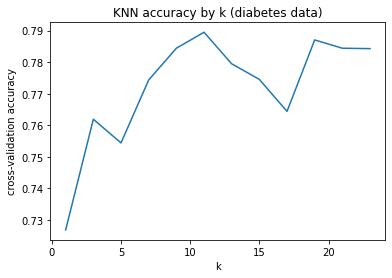

In [33]:
plt.plot(ks, cv_accuracy)
plt.title('KNN accuracy by k (diabetes data)')
plt.xlabel('k')
plt.ylabel('cross-validation accuracy');

The plot shows that a value of 11 is best, but 19 is almost as good.  Perhaps any value between about 11 and 21 is good.

### Find best combination of hyperparameters k and p using grid search

The problem with finding the best k value on its own, is that the best value of k might depend on the other hyperparameter values, such as distance function.

We really would like to search for the best combination of parameter values.  Grid search is a good way to do this.

In [34]:
#@ 12  Use GridSearchCV to find the best settings for hyperparameters 'n_neighbors', 
# 'weights', and 'p' of KNeighborsClassifier.  
# For 'n_neighbors', consider values 5, 7, 9, ..., 15.  
# For 'weights', consider values 'uniform' and 'distance'.
# For 'p', consider values 1 and 2.
# Use the training data to fit a GridSearchCV object.
# You do not need to do more than to do the fit here.

# YOUR CODE HERE
knn_cv = GridSearchCV(KNeighborsClassifier(), {'n_neighbors': range(5,16,2),
          'weights': ['uniform', 'distance'],
          'p': [1,2]}, cv = 10)
knn_cv.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': range(5, 16, 2), 'p': [1, 2],
                         'weights': ['uniform', 'distance']})

In [35]:
print(knn_cv.best_params_)

{'n_neighbors': 11, 'p': 2, 'weights': 'distance'}


In [36]:
print('best CV accuracy: {:.3f}'.format(knn_cv.best_score_))

best CV accuracy: 0.789


The CV accuracy we get with the best hyperparameter values is better than with the default hyperparameters.

### Train model with best hyperparameters on all training data.

Now that we've tuned our classifier, we will train it using all training data.

In [40]:
#@ 13  Using a KNN classifier with the best hyperparameter values that you
# found using grid search, train the classifier using the training data.
# Do *not* "hard code" the best hyperparameter values into your code.
# Hint: you can get the KNN classifier with the best hyperparameter settings
# using one of the attributes of a GridSearchCV object.  See the GridSearchCV
# documentation.

# YOUR CODE HERE


### Compute test accuracy using the score() function

We have not used the test data yet.  We now compute test accuracy to see how our classifier does on data never seen before.

In [38]:
#@ 14  Compute the test accuracy of your trained classifier using the test data.
# Use your classifier's score() function.
# Store the result in variable 'test_accuracy'.

# YOUR CODE HERE

In [39]:
print('Test accuracy: {:.3f}'.format(test_accuracy))

NameError: ignored

Our test accuracy is significantly better than our baseline accuracy, but only by about 10%.  

Some interesting questions:
- Could we do better with a different type of classification algorithm?
- Would we have done better if we had imputed the zero values?
- Which of the predictor values are most important?
- Could we do better if we drop some of the predictor variables?